In [1]:
TRAIN_SINGLE_DATASET_PATH = 'CompLex/train/lcp_single_train.tsv'
TEST_SINGLE_DATASET_PATH = 'CompLex/test-labels/lcp_single_test.tsv'
TRAIN_MULTI_DATASET_PATH = 'CompLex/train/lcp_multi_train.tsv'
TEST_MULTI_DATASET_PATH = 'CompLex/test-labels/lcp_multi_test.tsv'

LANGUAGE = 'english'

from gensim.models.fasttext import FastText
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf
import numpy as np
import pandas as pd
import itertools
import re
import csv

In [2]:
def load_dataframes():
    train_single_df = pd.read_csv(TRAIN_SINGLE_DATASET_PATH, sep='\t', quoting=csv.QUOTE_NONE)
    test_single_df = pd.read_csv(TEST_SINGLE_DATASET_PATH, sep='\t', quoting=csv.QUOTE_NONE)
    train_multi_df = pd.read_csv(TRAIN_MULTI_DATASET_PATH, sep='\t', quoting=csv.QUOTE_NONE)
    test_multi_df = pd.read_csv(TEST_MULTI_DATASET_PATH, sep='\t', quoting=csv.QUOTE_NONE)
    return train_single_df, test_single_df, train_multi_df, test_multi_df

def preprocess_data(sentences, language):
    language_stopwords = set(stopwords.words(language))

    sentences = [re.sub(r'[^a-zA-Z\s]', ' ', sentence).lower() for sentence in sentences]
    tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]
    tokenized_sentences = [
        [word for word in sentence if word not in language_stopwords]
        for sentence in tokenized_sentences
    ]

    return tokenized_sentences

def train_fasttext():
    wordnet_synset_examples = [synset.examples() for synset in wordnet.all_synsets()]
    wordnet_synset_examples = list(itertools.chain.from_iterable(wordnet_synset_examples))
    wordnet_synset_examples_tokenized = preprocess_data(wordnet_synset_examples, LANGUAGE)

    model = FastText(min_n=1, hs=True, size=100, window=5, alpha=0.001, min_alpha=0.0001, sg=True)
    model.build_vocab(sentences=wordnet_synset_examples_tokenized)
    model.train(sentences=wordnet_synset_examples_tokenized, total_examples=len(wordnet_synset_examples_tokenized), epochs=1)

    return model

def create_ml_dataset(df, nlp_fasttext):
    X = []
    Y = []

    for token, complexity in df[['token', 'complexity']].itertuples(index=False):
        if type(token) is not str:
            continue
        token = token.lower()
        token_embedding = nlp_fasttext.wv[token]

        X.append(token_embedding)
        Y.append(complexity)

    return X, Y

def create_ml_datasets(train_single_df, test_single_df, train_multi_df, test_multi_df, nlp_fasttext):
    return create_ml_dataset(train_single_df, nlp_fasttext), create_ml_dataset(test_single_df, nlp_fasttext), create_ml_dataset(train_multi_df, nlp_fasttext), create_ml_dataset(test_multi_df, nlp_fasttext)

In [3]:
train_single_df, test_single_df, train_multi_df, test_multi_df = load_dataframes()

nlp_fasttext = train_fasttext()

ml_single_train, ml_single_test, ml_multi_train, ml_multi_test = create_ml_datasets(train_single_df, test_single_df, train_multi_df, test_multi_df, nlp_fasttext)
ml_single_train_X, ml_single_train_Y = ml_single_train
ml_single_test_X, ml_single_test_Y = ml_single_test
ml_multi_train_X, ml_multi_train_Y = ml_multi_train
ml_multi_test_X, ml_multi_test_Y = ml_multi_test
ml_train_X = ml_single_train_X + ml_multi_train_X
ml_train_Y = ml_single_train_Y + ml_multi_train_Y

ml_train_X = np.array(ml_train_X)
ml_train_Y = np.array(ml_train_Y)

In [4]:
nlp_fasttext.save('models/FastText/model')

In [5]:
from sklearn.utils import all_estimators
from threading import Thread, Lock

import warnings
warnings.warn = lambda *args, **kwargs: None


regressor_results = {}

def launch_regressor(Regressor, regressor_name, X_train, Y_train, X_single_test, Y_single_test, X_multi_test, Y_multi_test):
    global regressor_results
    
    try:
        mdl = Regressor()
        mdl.fit(X_train, Y_train)
        
        Y_single_test_pred = mdl.predict(X_single_test)
        Y_multi_test_pred = mdl.predict(X_multi_test)
        
        single_test_mse = round(np.mean(tf.keras.losses.MSE(Y_single_test, Y_single_test_pred)), 6)
        multi_test_mse = round(np.mean(tf.keras.losses.MSE(Y_multi_test, Y_multi_test_pred)), 6)
        mean_mse = round((single_test_mse * len(Y_single_test_pred) + multi_test_mse * len(Y_multi_test_pred)) / (len(Y_single_test_pred) + len(Y_multi_test_pred)), 6)
        
        regressor_results[regressor_name] = {
            'Mean': mean_mse,
            'Single': single_test_mse,
            'Multi': multi_test_mse
        }
        
        print(regressor_name)
        print('Mean MSE:', mean_mse)
        print('Single-word expressions MSE:', single_test_mse)
        print('Multi-word expressions MSE:', multi_test_mse)
        print()
    except:
        pass

estimators = all_estimators(type_filter='regressor')

for regressor_name, Regressor in estimators:
    launch_regressor(Regressor, regressor_name, ml_train_X, ml_train_Y, ml_single_test_X, ml_single_test_Y, ml_multi_test_X, ml_multi_test_Y)

ARDRegression
Mean MSE: 0.018776
Single-word expressions MSE: 0.016761
Multi-word expressions MSE: 0.028821

AdaBoostRegressor
Mean MSE: 0.020313
Single-word expressions MSE: 0.019504
Multi-word expressions MSE: 0.024347

BaggingRegressor
Mean MSE: 0.017863
Single-word expressions MSE: 0.016564
Multi-word expressions MSE: 0.024337

BayesianRidge
Mean MSE: 0.0188
Single-word expressions MSE: 0.016761
Multi-word expressions MSE: 0.028964

CCA
Mean MSE: 0.028288
Single-word expressions MSE: 0.027977
Multi-word expressions MSE: 0.029837

DecisionTreeRegressor
Mean MSE: 0.030459
Single-word expressions MSE: 0.02812
Multi-word expressions MSE: 0.042117

DummyRegressor
Mean MSE: 0.019739
Single-word expressions MSE: 0.016816
Multi-word expressions MSE: 0.034305

ElasticNet
Mean MSE: 0.019739
Single-word expressions MSE: 0.016816
Multi-word expressions MSE: 0.034305

ElasticNetCV
Mean MSE: 0.019209
Single-word expressions MSE: 0.016829
Multi-word expressions MSE: 0.031068

ExtraTreeRegressor
M

In [19]:
optimal_regressor = min(list(regressor_results.items()), key=lambda x: x[1]['Mean']) 
print(optimal_regressor)

('HistGradientBoostingRegressor', {'Mean': 0.015212, 'Single': 0.013706, 'Multi': 0.022718})


In [9]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

hgbr = HistGradientBoostingRegressor()
hgbr.fit(ml_train_X, ml_train_Y)

HistGradientBoostingRegressor()

In [10]:
from joblib import dump

dump(hgbr, 'models/HistGradientBoostingRegressor/model')

['models/HistGradientBoostingRegressor/model']

In [28]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=1)
transformed_X = tsne.fit_transform(ml_single_test_X + ml_multi_test_X)

In [29]:
print(transformed_X)

[[ -0.13743097]
 [ -0.13743097]
 [ -0.13743097]
 ...
 [-25.882229  ]
 [-28.353895  ]
 [-28.352953  ]]


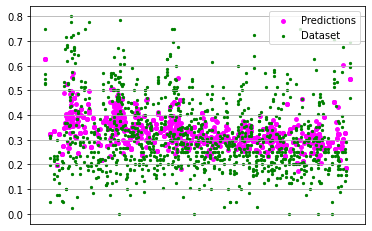

In [57]:
import matplotlib.pyplot as plt

ml_test_Y_pred = hgbr.predict(ml_single_test_X + ml_multi_test_X)

fig, ax = plt.subplots()
plt.scatter(transformed_X, ml_test_Y_pred, s=15, c='magenta', label='Predictions')
plt.scatter(transformed_X, ml_single_test_Y + ml_multi_test_Y, s=5, c='green', label='Dataset')

ax.legend()
ax.set_xticks([])
ax.grid(True)
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False
) 

plt.savefig('Predictions.png')
plt.show()

In [21]:
import tensorflow as tf


def create_nn(X_train, Y_train):
    mdl = tf.keras.Sequential([
        tf.keras.layers.Dense(units=3, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid)
    ])
    
    mdl.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.01),
        loss=tf.keras.losses.MSE
    )

    mdl.fit(X_train, Y_train, epochs=100, batch_size=100, verbose=True)

    return mdl

In [22]:
nn = create_nn(ml_train_X, ml_train_Y)

Epoch 1/100
92/92 [==============================] - 0s 1ms/step - loss: 0.0247
Epoch 2/100
92/92 [==============================] - 0s 894us/step - loss: 0.0204
Epoch 3/100
92/92 [==============================] - 0s 808us/step - loss: 0.0203
Epoch 4/100
92/92 [==============================] - 0s 890us/step - loss: 0.0203
Epoch 5/100
92/92 [==============================] - 0s 861us/step - loss: 0.0202
Epoch 6/100
92/92 [==============================] - 0s 931us/step - loss: 0.0202
Epoch 7/100
92/92 [==============================] - 0s 791us/step - loss: 0.0201
Epoch 8/100
92/92 [==============================] - 0s 893us/step - loss: 0.0201
Epoch 9/100
92/92 [==============================] - 0s 931us/step - loss: 0.0201
Epoch 10/100
92/92 [==============================] - 0s 866us/step - loss: 0.0201
Epoch 11/100
92/92 [==============================] - 0s 975us/step - loss: 0.0201
Epoch 12/100
92/92 [==============================] - 0s 936us/step - loss: 0.0200
Epoch 13/100
92

In [37]:
ml_single_test_Y_pred = nn.predict(np.array(ml_single_test_X))
ml_multi_test_Y_pred = nn.predict(np.array(ml_multi_test_X))

single_test_mse = round(np.mean(tf.keras.losses.MSE(ml_single_test_Y, ml_single_test_Y_pred)), 6)
multi_test_mse = round(np.mean(tf.keras.losses.MSE(ml_multi_test_Y, ml_multi_test_Y_pred)), 6)
mean_mse = round((single_test_mse * len(ml_single_test_Y_pred) + multi_test_mse * len(ml_multi_test_Y_pred)) / (len(ml_single_test_Y_pred) + len(ml_multi_test_Y_pred)), 6)

print('Mean MSE:', mean_mse)
print('Single-word expressions MSE:', single_test_mse)
print('Multi-word expressions MSE:', multi_test_mse)

regressor_results['Neural Network'] = {
    'Mean': mean_mse,
    'Single': single_test_mse,
    'Multi': multi_test_mse
}

Mean MSE: 0.02002
Single-word expressions MSE: 0.017608
Multi-word expressions MSE: 0.032042


In [38]:
import copy
from tabulate import tabulate


sorted_regressor_results = list(regressor_results.items())

sorted_regressor_results.sort(key=lambda x: x[1]['Mean'])
sorted_regressor_results_mean = copy.deepcopy(sorted_regressor_results)

sorted_regressor_results.sort(key=lambda x: x[1]['Single'])
sorted_regressor_results_single = copy.deepcopy(sorted_regressor_results)

sorted_regressor_results.sort(key=lambda x: x[1]['Multi'])
sorted_regressor_results_multi = copy.deepcopy(sorted_regressor_results)

In [39]:
print(tabulate([(el[0], el[1]['Mean'], el[1]['Single'], el[1]['Multi']) for el in sorted_regressor_results_mean], headers=['Regressor', 'Mean MSE', 'Single-word MSE', 'Multi-word MSE']))

Regressor                        Mean MSE    Single-word MSE    Multi-word MSE
-----------------------------  ----------  -----------------  ----------------
HistGradientBoostingRegressor    0.015212           0.013706          0.022718
ExtraTreesRegressor              0.016234           0.014948          0.022644
GradientBoostingRegressor        0.016256           0.014446          0.025278
RandomForestRegressor            0.016412           0.014893          0.023985
SVR                              0.017308           0.015463          0.026501
NuSVR                            0.017383           0.015485          0.026844
BaggingRegressor                 0.018269           0.017102          0.024083
LassoLarsIC                      0.018766           0.016749          0.028819
ARDRegression                    0.018772           0.016758          0.02881
BayesianRidge                    0.018798           0.01676           0.028957
OrthogonalMatchingPursuit        0.018876           0

In [40]:
for el in sorted_regressor_results_mean:
    print('{}&{}&{}&{}\\\\'.format(el[0], round(el[1]['Mean'], 6), round(el[1]['Single'], 6), round(el[1]['Multi'], 6)))

HistGradientBoostingRegressor&0.015212&0.013706&0.022718\\
ExtraTreesRegressor&0.016234&0.014948&0.022644\\
GradientBoostingRegressor&0.016256&0.014446&0.025278\\
RandomForestRegressor&0.016412&0.014893&0.023985\\
SVR&0.017308&0.015463&0.026501\\
NuSVR&0.017383&0.015485&0.026844\\
BaggingRegressor&0.018269&0.017102&0.024083\\
LassoLarsIC&0.018766&0.016749&0.028819\\
ARDRegression&0.018772&0.016758&0.02881\\
BayesianRidge&0.018798&0.01676&0.028957\\
OrthogonalMatchingPursuit&0.018876&0.016595&0.030244\\
LinearRegression&0.018942&0.01699499972164631&0.02864300087094307\\
TransformedTargetRegressor&0.018942&0.01699499972164631&0.02864300087094307\\
LassoLarsCV&0.019183&0.016727&0.031422\\
LassoCV&0.019197&0.016819000244140625&0.0310479998588562\\
ElasticNetCV&0.019206&0.016829000785946846&0.03105499967932701\\
RidgeCV&0.019266&0.016876&0.03118\\
LarsCV&0.019331&0.016674&0.032573\\
HuberRegressor&0.019359&0.017132&0.030456\\
OrthogonalMatchingPursuitCV&0.019365&0.017055&0.030877\\
MLPRegre